<a href="https://colab.research.google.com/github/heyychandan/Advanced-Sentiment-Analyzer/blob/main/Sentiment_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nltk pandas


In [3]:
!pip install text2emotion

In [5]:
!pip uninstall -y emoji
!pip install emoji==1.7.0

Found existing installation: emoji 1.7.0
Uninstalling emoji-1.7.0:
  Successfully uninstalled emoji-1.7.0
  Using cached emoji-1.7.0-py3-none-any.whl


In [3]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import text2emotion as te # ADDED for emotion analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet') # Good for general NLP stability

print("Setup complete. All necessary NLTK resources downloaded.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...


Setup complete. All necessary NLTK resources downloaded.


[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
!pip install tensorflow-datasets

import tensorflow_datasets as tfds

print("Downloading and preparing IMDB dataset from TensorFlow Datasets...")
ds, ds_info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# We will use only the first 5000 reviews from the 'train' split for analysis speed.
reviews_list = []
for review, label in ds[0].take(5000):
    reviews_list.append({
        'text': review.numpy().decode('utf-8'),
        'sentiment_label': label.numpy()
    })

df = pd.DataFrame(reviews_list)

# The sentiment_label is 0 for negative, 1 for positive.
# We will still run VADER on the 'text' column to compare VADER's score vs. the true label.

# Final DataFrame for analysis
df_sample = df.sample(n=5000, random_state=42).reset_index(drop=True)

print(f"\nData successfully loaded. Analysis will be performed on {len(df_sample)} reviews.")
print("\n--- First 5 reviews (IMDB Dataset) ---")
print(df_sample.head())


Data successfully loaded. Analysis will be performed on 5000 reviews.

--- First 5 reviews (IMDB Dataset) ---
                                                text  sentiment_label
0  Or released on DVD or screened on a cable chan...                1
1  This movie is not about entertainment, or not ...                1
2  Man on fire, is definitely one of the best dra...                1
3  This film is the most cult movie on metal ther...                1
4  Description: Corny, utterly stupid and worthle...                0


In [5]:
import text2emotion as te

def analyze_emotion(text):
    """
    Analyzes text and returns the emotion with the highest score.
    Emotions detected: Happy, Angry, Sad, Fear, Surprised.
    """
    # Get scores for all 5 emotions
    emotion_scores = te.get_emotion(text)

    # Find the emotion with the maximum score
    if not emotion_scores:
        return "Cannot Determine Emotion"

    # Find the key (emotion name) that corresponds to the maximum value
    highest_emotion = max(emotion_scores, key=emotion_scores.get)
    highest_score = emotion_scores[highest_emotion]

    # Return a descriptive result based on the score and emotion
    if highest_score < 0.2:
        return "No Strong Emotion Detected"

    # Create descriptive phrases based on the score and the emotion label
    if highest_emotion == 'Happy':
        if highest_score > 0.6:
            return "Extremely Happy! 😄"
        return "Happy 😊"

    if highest_emotion == 'Angry':
        if highest_score > 0.6:
            return "Highly Angry 😡"
        return "Angry 😠"

    if highest_emotion == 'Sad':
        if highest_score > 0.6:
            return "Very Sad 😢"
        return "Sad 🙁"

    # For Fear/Surprised, we just return the emotion if strong enough
    return f"{highest_emotion} (Score: {highest_score:.2f})"

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # Ensure this is imported
vader = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text):
    """
    Uses the VADER lexicon to get sentiment scores.
    Returns the compound score.
    """
    scores = vader.polarity_scores(text)
    return scores['compound']


--- Final Sentiment Analysis Results (First 10) ---
                                                text  VADER_Compound  \
0  Or released on DVD or screened on a cable chan...          0.8122   
1  This movie is not about entertainment, or not ...          0.9992   
2  Man on fire, is definitely one of the best dra...          0.9821   
3  This film is the most cult movie on metal ther...          0.7177   
4  Description: Corny, utterly stupid and worthle...         -0.9261   
5  I was not entirely impressed by this film. It ...         -0.6081   
6  In a lot of his films (Citizen Kane, Confident...          0.9516   
7  While the overall idea of Escape from Atlantis...          0.9875   
8  The ultimate goal of Big Brother, that we know...         -0.8414   
9  The title of this film is taken from a party g...          0.9022   

  VADER_Sentiment  sentiment_label  
0        Positive                1  
1        Positive                1  
2        Positive                1  
3     

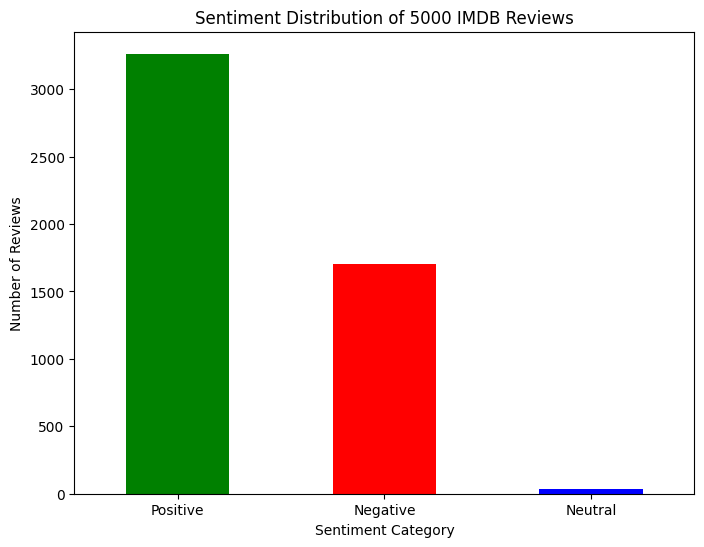


--- Distribution Summary ---
VADER_Sentiment
Positive    3262
Negative    1700
Neutral       38
Name: count, dtype: int64


In [7]:
# Apply the VADER function to the entire 'text' column of your sampled DataFrame
df_sample['VADER_Compound'] = df_sample['text'].apply(analyze_sentiment_vader)

# Define the classifier based on the Compound Score (thresholds are industry standard)
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the classifier
df_sample['VADER_Sentiment'] = df_sample['VADER_Compound'].apply(classify_sentiment)

print("\n--- Final Sentiment Analysis Results (First 10) ---")
print(df_sample[['text', 'VADER_Compound', 'VADER_Sentiment', 'sentiment_label']].head(10))

# --- Visualization (Added for Resume Value) ---
plt.figure(figsize=(8, 6))
# Count the occurrences of each sentiment label
sentiment_counts = df_sample['VADER_Sentiment'].value_counts()
# Create a bar chart
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution of 5000 IMDB Reviews')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

print("\n--- Distribution Summary ---")
print(sentiment_counts)

In [ ]:
# Interactive Sentiment and Emotion Test

print("\n\n--- 🤖 Interactive Sentiment and Emotion Analyzer ---")
print("Enter any sentence to get its VADER score and specific emotion. Type 'quit' to exit.")

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import text2emotion as te
vader = SentimentIntensityAnalyzer()

# VADER Analysis Functions

def analyze_sentiment_vader(text):
    """Returns the VADER compound score."""
    scores = vader.polarity_scores(text)
    return scores['compound']

def classify_sentiment_intensity(score):
    """Classifies score into tiered intensity levels."""
    if score >= 0.7:
        return 'Highly Positive 😊'
    elif score >= 0.3:
        return 'Positive 👍'
    elif score >= 0.05:
        return 'Slightly Positive 🙂'
    elif score <= -0.7:
        return 'Highly Negative 😡'
    elif score <= -0.3:
        return 'Negative 👎'
    elif score <= -0.05:
        return 'Slightly Negative 🙁'
    else:
        return 'Neutral 😐'

# Emotion Analysis Function (Text2Emotion)
def analyze_emotion(text):
    """
    Analyzes text and returns the emotion with the highest score.
    Emotions detected: Happy, Angry, Sad, Fear, Surprised.
    """
    emotion_scores = te.get_emotion(text)

    # Handle cases where no emotion is strongly detected
    if not emotion_scores or max(emotion_scores.values()) < 0.2:
        return "No Strong Emotion Detected"

    # Find the key (emotion name) that corresponds to the maximum value
    highest_emotion = max(emotion_scores, key=emotion_scores.get)
    highest_score = emotion_scores[highest_emotion]

    # Return descriptive phrases
    if highest_emotion == 'Happy':
        return f"Happy (Score: {highest_score:.2f})"
    if highest_emotion == 'Angry':
        return f"Angry (Score: {highest_score:.2f})"
    if highest_emotion == 'Sad':
        return f"Sad (Score: {highest_score:.2f})"

    # For others, just return the name and score
    return f"{highest_emotion} (Score: {highest_score:.2f})"

# Interactive Loop
while True:
    try:
        user_input = input("Enter statement: ")

        if user_input.lower() in ["quit", "exit"]:
            print("Exiting interactive mode. Goodbye!")
            break

        if not user_input.strip():
            continue

        # VADER (Polarity/Intensity) Analysis
        compound_score = analyze_sentiment_vader(user_input)
        sentiment_result = classify_sentiment_intensity(compound_score)

        # Emotion (Specific Label) Analysis
        emotion_result = analyze_emotion(user_input)

        # Print the Combined Results
        print("-" * 50)
        print(f"Polarity Classification: **{sentiment_result}**")
        print(f"Specific Emotion:        {emotion_result}")
        print(f"VADER Compound Score:    {compound_score:.4f}")
        print("-" * 50)

    except Exception as e:
        print(f"An error occurred: {e}")
        break



--- 🤖 Interactive Sentiment and Emotion Analyzer ---
Enter any sentence to get its VADER score and specific emotion. Type 'quit' to exit.
Enter statement: i am happy
--------------------------------------------------
Polarity Classification: **Positive 👍**
Specific Emotion:        Happy (Score: 1.00)
VADER Compound Score:    0.5719
--------------------------------------------------
Enter statement: i am so excited
--------------------------------------------------
Polarity Classification: **Positive 👍**
Specific Emotion:        Sad (Score: 1.00)
VADER Compound Score:    0.4005
--------------------------------------------------
Enter statement: i am so happy
--------------------------------------------------
Polarity Classification: **Positive 👍**
Specific Emotion:        Happy (Score: 1.00)
VADER Compound Score:    0.6115
--------------------------------------------------
Enter statement: i am crying
--------------------------------------------------
Polarity Classification: **Negati